In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from tensorflow.keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, AveragePooling2D, Flatten
from keras.callbacks import EarlyStopping
from tensorflow.keras import layers
from keras import models, layers
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization
import time

In [2]:
# import data
# all_data = pd.read_csv('w207_final_project_hold/data/icml_face_data.csv')
all_data = pd.read_csv('../input/facial-expression-recognition-challenge/icml_face_data.csv/icml_face_data.csv')
# all_data = all_data[0:700] # just for dev... remove for actual training
print(all_data.shape)

accuracy = {}
params = {}

(35887, 3)


In [3]:
# Preprocessing 
all_data.rename({' Usage': 'Usage', ' pixels': 'pixels'}, axis=1, inplace=True)

In [4]:
def pixels_to_arr(pixels):
    array = np.array(pixels.split(),'float64')
    return array

all_data['pixels_arr'] = all_data['pixels'].apply(pixels_to_arr)

In [5]:
def image_reshape(data):
    image = np.reshape(data['pixels_arr'].to_list(),(data.shape[0],48,48,1))/255
    return image

X = image_reshape(all_data)
y = all_data['emotion']

In [6]:
# Split
X_train_im, X_test_im, y_train_im, y_test_im = train_test_split(X, y, test_size=0.2, random_state=12345)
X_train_im, X_val_im, y_train_im, y_val_im = train_test_split(X_train_im, y_train_im, test_size=0.25, random_state=1)

print("Converted Images")
print("Training data shape: ", X_train_im.shape)
print("Test data shape", X_test_im.shape)
print("Validation data shape", X_val_im.shape)

Converted Images
Training data shape:  (21531, 48, 48, 1)
Test data shape (7178, 48, 48, 1)
Validation data shape (7178, 48, 48, 1)


In [7]:
train_labels = to_categorical(y_train_im)
val_labels = to_categorical(y_test_im)
test_labels = to_categorical(y_val_im)

In [8]:
classes = dict(zip(range(0, 7), (((all_data[all_data['Usage']=='Training']['emotion'].value_counts()).sort_index())/len(all_data[all_data['Usage']=='Training']['emotion'])).tolist()))

In [9]:
# Defining function that creates model. Need this to implement KerasClassifier and GridSearchCV
def create_model(): 
    model_cnn = models.Sequential()
    model_cnn.add(Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)))
    model_cnn.add(MaxPooling2D((2, 2)))
    model_cnn.add(Conv2D(64, (3, 3), activation='relu'))
    model_cnn.add(MaxPooling2D((2, 2)))
    model_cnn.add(Conv2D(64, (3, 3), activation='relu'))
    model_cnn.add(Flatten())
    model_cnn.add(Dense(64, activation='relu'))
    model_cnn.add(Dense(7, activation='softmax'))
    model_cnn.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
    return model_cnn

In [10]:
# define parameters for grid search and training 
param_grid = {
    'batch_size': [32, 64],
    'epochs': [1, 2, 3, 4, 5, 10, 25, 50]
}

model_test = KerasClassifier(build_fn=create_model, verbose=1)
grid = GridSearchCV(estimator=model_test, param_grid=param_grid, cv=5)#, scoring="accuracy")
grid_result = grid.fit(X, to_categorical(y))  


2021-12-06 23:32:32.461414: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-06 23:32:32.572743: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-06 23:32:32.573508: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-06 23:32:32.574912: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

225/225 [==============================] - 1s 3ms/step - loss: 1.5107 - accuracy: 0.4275
Epoch 1/2
898/898 [==============================] - 4s 4ms/step - loss: 1.6266 - accuracy: 0.3604
Epoch 2/2
225/225 [==============================] - 1s 3ms/step - loss: 1.3584 - accuracy: 0.4862
Epoch 1/2
898/898 [==============================] - 4s 4ms/step - loss: 1.6572 - accuracy: 0.3449
Epoch 2/2
225/225 [==============================] - 1s 3ms/step - loss: 1.3803 - accuracy: 0.4688
Epoch 1/2
898/898 [==============================] - 4s 4ms/step - loss: 1.6653 - accuracy: 0.3433
Epoch 2/2
225/225 [==============================] - 1s 3ms/step - loss: 1.3812 - accuracy: 0.4683
Epoch 1/2
898/898 [==============================] - 4s 4ms/step - loss: 1.6722 - accuracy: 0.3338
Epoch 2/2
225/225 [==============================] - 1s 3ms/step - loss: 1.3633 - accuracy: 0.4803
Epoch 1/2
898/898 [==============================] - 4s 4ms/step - loss: 1.6341 - accuracy: 0.3560
Epoch 2/2
225/225 [=

In [11]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.552206 using {'batch_size': 64, 'epochs': 10}


In [12]:
# Taking the best parameters and properly training
best_params = grid_result.best_params_

final_model = create_model()

history = final_model.fit(X_train_im, train_labels,
                    validation_data=(X_val_im, val_labels),
                    class_weight = classes,
                    epochs = best_params['epochs'],
                    batch_size = best_params['batch_size'])
final_model.summary()

Epoch 1/10
337/337 [==============================] - 3s 6ms/step - loss: 0.2769 - accuracy: 0.2844 - val_loss: 2.1279 - val_accuracy: 0.2123
Epoch 2/10
337/337 [==============================] - 2s 6ms/step - loss: 0.2425 - accuracy: 0.3932 - val_loss: 2.1239 - val_accuracy: 0.1860
Epoch 3/10
337/337 [==============================] - 2s 5ms/step - loss: 0.2232 - accuracy: 0.4447 - val_loss: 2.4659 - val_accuracy: 0.1917
Epoch 4/10
337/337 [==============================] - 2s 6ms/step - loss: 0.2090 - accuracy: 0.4833 - val_loss: 2.5691 - val_accuracy: 0.1955
Epoch 5/10
337/337 [==============================] - 2s 6ms/step - loss: 0.1988 - accuracy: 0.5051 - val_loss: 2.6907 - val_accuracy: 0.1838
Epoch 6/10
337/337 [==============================] - 2s 6ms/step - loss: 0.1897 - accuracy: 0.5310 - val_loss: 2.6918 - val_accuracy: 0.1882
Epoch 7/10
337/337 [==============================] - 2s 6ms/step - loss: 0.1824 - accuracy: 0.5469 - val_loss: 2.8402 - val_accuracy: 0.1803
Epoch 

In [13]:
test_prob = final_model.predict(X_test_im)
y_pred = np.argmax(test_prob, axis=1)
test_accuracy = np.mean(y_pred == y_test_im)

print(test_accuracy)

0.5346893285037615


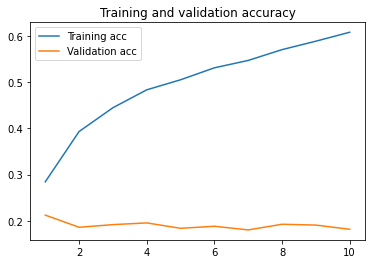

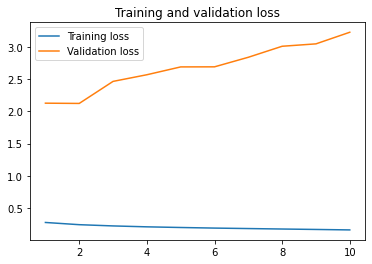

In [14]:
# Visualization
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()